In [1]:
using Plots
using Flux
using DiffEqFlux
using OrdinaryDiffEq

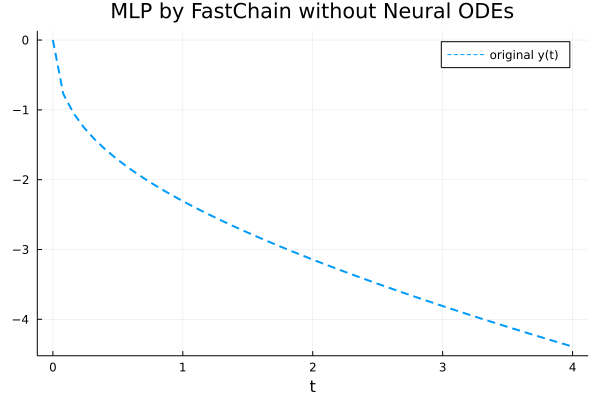

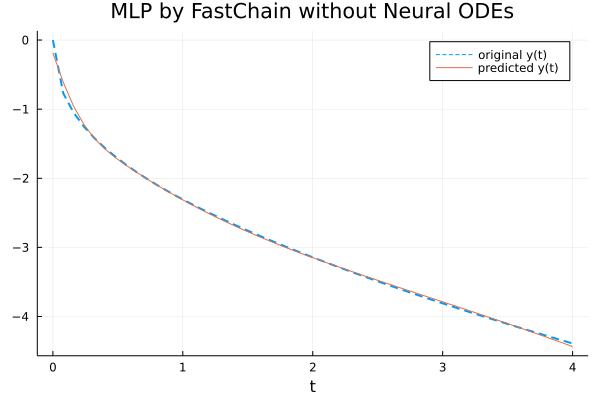

 44.874794 seconds (104.12 M allocations: 6.820 GiB, 4.70% gc time, 99.11% compilation time)
  0.004352 seconds (892 allocations: 178.526 KiB, 96.22% compilation time)


In [2]:
tbegin = 0.0
tend = 4.0
datasize = 51
dataset_in = range(tbegin, tend, length=datasize)
dataset_out = log.(1 .+ dataset_in) .- 3 * sqrt.(dataset_in)

function neural_network(data_dim)
    fc = FastChain(FastDense(data_dim, 64, swish),
                  FastDense(64, 32, swish),
                  FastDense(32, data_dim))
end

nn = neural_network(1)
theta = initial_params(nn)

predict(t, p) = nn(t', p)'

loss(p) = begin
  yhat = predict(dataset_in, p)
  l = Flux.mse(yhat, dataset_out)
end

learning_rate=1e-2
opt = ADAMW(learning_rate)
epochs = 500

function cb_train(theta, loss)
    #println("Loss: ", loss)
    false
end

@time res_train = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

@time y_pred = predict(dataset_in, res_train.minimizer)

pl = plot(
    dataset_in,
    dataset_out,
    linewidth=2, ls=:dash,
    title="MLP by FastChain without Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)
display(pl)

pl = plot!(
    dataset_in,
    y_pred,
    linewidth=1,
    label="predicted y(t)")
display(pl)

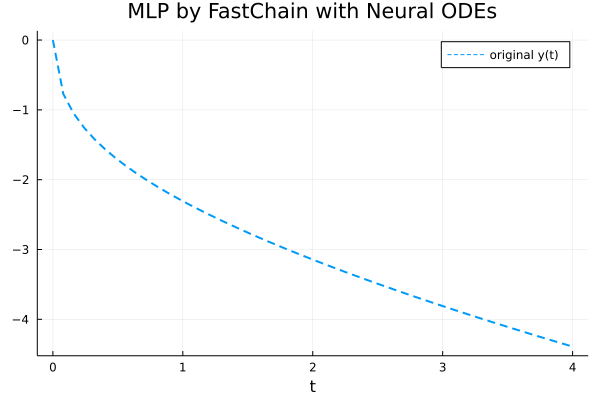

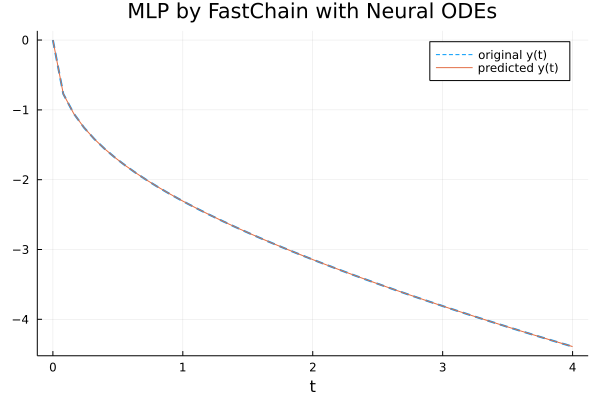

209.867950 seconds (387.50 M allocations: 364.065 GiB, 25.08% gc time, 0.14% compilation time)
  0.007990 seconds (20.83 k allocations: 17.444 MiB)


In [10]:
tbegin = 0.0
tend = 4.0
datasize = 51
dataset_in = range(tbegin, tend, length=datasize)
dataset_out = log.(1 .+ dataset_in) .-  3 * sqrt.(dataset_in)

function neural_ode(data_dim; saveat = dataset_in)
    fc = FastChain(FastDense(data_dim, 64, swish),
                  FastDense(64, 32, swish),
                  FastDense(32, data_dim))

    n_ode = NeuralODE(
            fc,
            (minimum(dataset_in), maximum(dataset_in)),
            Tsit5(),
            saveat = saveat,
            abstol = 1e-9, reltol = 1e-9)
end

n_ode = neural_ode(1)
theta = n_ode.p

predict(p) = n_ode(dataset_out[1:1], p)'

loss(p) = begin
  yhat = predict(p)
  l = Flux.mse(yhat, dataset_out)
end

learning_rate=1e-2
opt = BFGS()
epochs = 500

function cb_train(theta, loss)
    #println("Loss: ", loss)
    false
end

@time res_train = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

@time y_pred = predict(res_train.minimizer)

pl = plot(
    dataset_in,
    dataset_out,
    linewidth=2, ls=:dash,
    title="MLP by FastChain with Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)
display(pl)

pl = plot!(
    dataset_in,
    y_pred,
    linewidth=1,
    label="predicted y(t)")
display(pl)